In [1]:
import os
import sys
import rrdtool
import pickle
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from auserverdata.preparation.rrd import (
    parse_rrds_for_all_collectd_servers,
    parse_rrds_for_all_snmp_servers,
    get_time_series_data_for_collectd_servers,
    get_time_series_data_for_snmp_servers,
    map_features_to_timestamps,
    map_timestamp_set_to_features,
    print_timestamp_set_to_features_map_info
)
from auserverdata.local import get_local_config
from auserverdata.analysis import plot_time_series_data
from joblib import Parallel,delayed
import pyarrow.parquet as pq
import pyarrow.compute as pc

In [2]:
local_config = get_local_config()

In [69]:
# results = parse_rrds_for_all_snmp_servers(snmp_path='/home/bshook/Projects/server-log-api/rrd/original/snmp', 
#                                           dst=f'/home/bshook/Projects/server-log-api/rrd/parsed/snmp_parsed_data.parquet')

In [70]:
# results = parse_rrds_for_all_collectd_servers(collectd_path='/home/bshook/Projects/server-log-api/rrd/original/collectd', 
#                                               dst=f'/home/bshook/Projects/server-log-api/rrd/parsed/collectd/parsed_data.parquet',
#                                               n_jobs=-1)

In [3]:
collectd_ts_df = get_time_series_data_for_collectd_servers(rrd_dir=local_config.rrd_dir, collectd_servers=['gpu1'])

In [5]:
timestamps_per_feature = map_features_to_timestamps(collectd_ts_df)
features_per_timestamp_set = map_timestamp_set_to_features(timestamps_per_feature)

In [6]:
print_timestamp_set_to_features_map_info(features_per_timestamp_set)

************************************************************
Info about Timestamp Set 0
    Number of timestamps: 1200
    Number of features with the these timestamps: 225
    Step size between timestamps: 0 days 00:00:10
    Start timestamp: 2023-05-20 00:51:28
    End timestamp: 2023-05-20 04:11:18
    Total duration: 0 days 03:19:50
************************************************************
Info about Timestamp Set 1
    Number of timestamps: 1200
    Number of features with the these timestamps: 8
    Step size between timestamps: 0 days 00:00:10
    Start timestamp: 2023-05-20 00:51:33
    End timestamp: 2023-05-20 04:11:23
    Total duration: 0 days 03:19:50
************************************************************
Info about Timestamp Set 2
    Number of timestamps: 1200
    Number of features with the these timestamps: 1
    Step size between timestamps: 0 days 00:00:10
    Start timestamp: 2020-07-09 14:49:41
    End timestamp: 2020-07-09 18:09:31
    Total duration: 0 d

In [4]:
collectd_ts_df

server                  gpu1                                               \
component              cpu-0                                                
rrd                 cpu-idle cpu-interrupt cpu-nice cpu-softirq cpu-steal   
data_source            value         value    value       value     value   
time                                                                        
2019-07-24 07:02:46      NaN           NaN      NaN         NaN       NaN   
2019-07-24 07:02:56      NaN           NaN      NaN         NaN       NaN   
2019-07-24 07:03:06      NaN           NaN      NaN         NaN       NaN   
2019-07-24 07:03:16      NaN           NaN      NaN         NaN       NaN   
2019-07-24 07:03:26      NaN           NaN      NaN         NaN       NaN   
...                      ...           ...      ...         ...       ...   
2023-05-20 04:11:13      NaN           NaN      NaN         NaN       NaN   
2023-05-20 04:11:15      NaN           NaN      NaN         NaN       NaN   
2023-05-20 04:11:16      NaN           NaN      NaN         NaN       NaN   
2023-05-20 04:11:18     99.6           0.0      0.0         0.0       0.0   
2023-05-20 04:11:23      NaN           NaN      NaN         NaN       NaN   

server                                                                   ...  \
component                                           cpu-1                ...   
rrd                 cpu-system cpu-user cpu-wait cpu-idle cpu-interrupt  ...   
data_source              value    value    value    value         value  ...   
time                                                                     ...   
2019-07-24 07:02:46        NaN      NaN      NaN      NaN           NaN  ...   
2019-07-24 07:02:56        NaN      NaN      NaN      NaN           NaN  ...   
2019-07-24 07:03:06        NaN      NaN      NaN      NaN           NaN  ...   
2019-07-24 07:03:16        NaN      NaN      NaN      NaN           NaN  ...   
2019-07-24 07:03:26        NaN      NaN      NaN      NaN           NaN  ...   
...                        ...      ...      ...      ...           ...  ...   
2023-05-20 04:11:13        NaN      NaN      NaN      NaN           NaN  ...   
2023-05-20 04:11:15        NaN      NaN      NaN      NaN           NaN  ...   
2023-05-20 04:11:16        NaN      NaN      NaN      NaN           NaN  ...   
2023-05-20 04:11:18       0.08      0.0     0.18     99.9           0.0  ...   
2023-05-20 04:11:23        NaN      NaN      NaN      NaN           NaN  ...   

server                                                           \
component           sensors-coretemp-isa-0000                     
rrd                         temperature-temp6 temperature-temp7   
data_source                             value             value   
time                                                              
2019-07-24 07:02:46                       NaN               NaN   
2019-07-24 07:02:56                       NaN               NaN   
2019-07-24 07:03:06                       NaN               NaN   
2019-07-24 07:03:16                       NaN               NaN   
2019-07-24 07:03:26                       NaN               NaN   
...                                       ...               ...   
2023-05-20 04:11:13                       NaN               NaN   
2023-05-20 04:11:15                      26.5              24.0   
2023-05-20 04:11:16                       NaN               NaN   
2023-05-20 04:11:18                       NaN               NaN   
2023-05-20 04:11:23                       NaN               NaN   

server                                                           \
component           sensors-coretemp-isa-0001                     
rrd                         temperature-temp1 temperature-temp2   
data_source                             value             value   
time                                                              
2019-07-24 07:02:46                       NaN               NaN   
2019-07-24 

In [212]:
component_rrd_df = pd.DataFrame(pd.Series(collectd_features_with_matching_timestamps[225].columns.droplevel(['data_source', 'server']).unique().to_numpy()).apply(lambda x: pd.Series(x)))
component_rrd_df.columns = ['component', 'rrd']

In [87]:
component_rrd_df['component'].value_counts().sort_index()

component
cpu-0             8
cpu-1             8
cpu-10            8
cpu-11            8
cpu-12            8
cpu-13            8
cpu-14            8
cpu-15            8
cpu-16            8
cpu-17            8
cpu-18            8
cpu-19            8
cpu-2             8
cpu-20            8
cpu-21            8
cpu-22            8
cpu-23            8
cpu-3             8
cpu-4             8
cpu-5             8
cpu-6             8
cpu-7             8
cpu-8             8
cpu-9             8
interface-eno1    4
interface-eno2    4
interface-lo      4
load              1
memory            6
Name: count, dtype: int64

In [88]:
collectd_features_with_matching_timestamps[225].groupby(['rrd'])

KeyError: 'rrd'

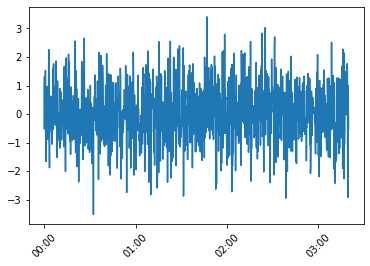

In [111]:
# Generate some example data
# Replace this with your actual time series data and timestamps
timestamps = [datetime(2023, 9, 26, 0, 0, 0) + timedelta(seconds=i*10) for i in range(1200)]
data = np.random.randn(1200)

# Create the figure and axes
fig, ax = plt.subplots()

# Plot your data
ax.plot(timestamps, data)

# Set the x-axis locator to show hours
ax.xaxis.set_major_locator(HourLocator(interval=1))  # This sets the tick interval to 1 hour

# Format the x-axis tick labels as hour:minute
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))

# Rotate the tick labels for better readability (optional)
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [113]:
ax.get_xticklabels()

[Text(19626.0, 0, '00:00'),
 Text(19626.041666666668, 0, '01:00'),
 Text(19626.083333333332, 0, '02:00'),
 Text(19626.125, 0, '03:00')]

In [ ]:
# These components share timestamps
collectd_features_with_matching_timestamps[225].columns.levels[1]

Index(['cpu-0', 'cpu-1', 'cpu-10', 'cpu-11', 'cpu-12', 'cpu-13', 'cpu-14',
       'cpu-15', 'cpu-16', 'cpu-17', 'cpu-18', 'cpu-19', 'cpu-2', 'cpu-20',
       'cpu-21', 'cpu-22', 'cpu-23', 'cpu-3', 'cpu-4', 'cpu-5', 'cpu-6',
       'cpu-7', 'cpu-8', 'cpu-9', 'dns', 'interface-eno1', 'interface-eno2',
       'interface-lo', 'ipmi', 'load', 'memory', 'sensors-coretemp-isa-0000',
       'sensors-coretemp-isa-0001', 'sensors-i350bb-pci-8100'],
      dtype='object', name='component')

In [ ]:
# These RRDs share timestamps
collectd_features_with_matching_timestamps[225].columns.levels[2]

Index(['cpu-idle', 'cpu-interrupt', 'cpu-nice', 'cpu-softirq', 'cpu-steal',
       'cpu-system', 'cpu-user', 'cpu-wait', 'dns_octets', 'dns_opcode-Query',
       'dns_qtype-#1', 'dns_qtype-#12', 'dns_qtype-#15', 'dns_qtype-#28',
       'dns_rcode-RCode0', 'dns_rcode-RCode2', 'dns_rcode-RCode3',
       'fanspeed-FAN1 fan_cooling (29.1)', 'fanspeed-FAN2 fan_cooling (29.2)',
       'fanspeed-FAN3 fan_cooling (29.3)', 'fanspeed-FAN4 fan_cooling (29.4)',
       'fanspeed-FAN5 fan_cooling (29.5)', 'fanspeed-FAN6 fan_cooling (29.6)',
       'fanspeed-FANA fan_cooling (29.7)', 'fanspeed-FANB fan_cooling (29.8)',
       'fanspeed-FANC fan_cooling (29.9)', 'fanspeed-FAND fan_cooling (29.10)',
       'if_dropped', 'if_errors', 'if_octets', 'if_packets', 'load',
       'memory-buffered', 'memory-cached', 'memory-free', 'memory-slab_recl',
       'memory-slab_unrecl', 'memory-used',
       'temperature-CPU1 Temp processor (3.1)',
       'temperature-CPU2 Temp processor (3.2)',
       'temperature-G

In [ ]:
collectd_server = 'gpu1'
component = 'cpu-0'
rrd = 'cpu-softirq'

In [ ]:
collectd_ts = get_time_series_data_for_collectd_servers(local_config.rrd_dir, collectd_servers=['gpu1', 'gpu2'])

In [ ]:
collectd_ts['gpu1']['cpu-0']['cpu-softirq'].dropna()

data_source,value
time,
2023-05-20 00:51:28,0.00
2023-05-20 00:51:38,0.00
2023-05-20 00:51:48,0.00
2023-05-20 00:51:58,0.00
2023-05-20 00:52:08,0.00
...,...
2023-05-20 04:10:38,0.08
2023-05-20 04:10:48,0.00
2023-05-20 04:10:58,0.00


In [ ]:
collectd_ts['gpu1']['ipmi']['fanspeed-FAN1 fan_cooling (29.1)'].dropna()

data_source,value
time,
2023-05-20 00:51:25,2900.0
2023-05-20 00:51:35,2900.0
2023-05-20 00:51:45,2900.0
2023-05-20 00:51:55,2900.0
2023-05-20 00:52:05,2900.0
...,...
2023-05-20 04:10:35,2800.0
2023-05-20 04:10:45,2850.0
2023-05-20 04:10:55,2850.0


In [ ]:
collectd_ts['gpu1']['ipmi']['temperature-CPU1 Temp processor (3.1)'].dropna()

data_source,value
time,
2023-05-20 00:51:26,33.0
2023-05-20 00:51:36,33.0
2023-05-20 00:51:46,33.0
2023-05-20 00:51:56,33.0
2023-05-20 00:52:06,33.0
...,...
2023-05-20 04:10:36,31.0
2023-05-20 04:10:46,31.5
2023-05-20 04:10:56,31.6


In [ ]:
collectd_ts['gpu2']['cpu-0']['cpu-softirq'].dropna()

data_source,value
time,
2023-07-19 22:37:01,0.0
2023-07-19 22:37:11,0.0
2023-07-19 22:37:21,0.0
2023-07-19 22:37:31,0.0
2023-07-19 22:37:41,0.0
...,...
2023-07-20 01:56:11,0.0
2023-07-20 01:56:21,0.0
2023-07-20 01:56:31,0.0


In [ ]:
collectd_ts['gpu1']['cpu-3']['cpu-idle'].dropna()

data_source,value
time,
2023-05-20 00:51:28,99.82
2023-05-20 00:51:38,99.90
2023-05-20 00:51:48,99.90
2023-05-20 00:51:58,99.88
2023-05-20 00:52:08,99.82
...,...
2023-05-20 04:10:38,99.72
2023-05-20 04:10:48,99.82
2023-05-20 04:10:58,99.84


In [ ]:
collectd_ts['gpu1']['cpu-5']['cpu-softirq'].dropna()

data_source,value
time,
2023-05-20 00:51:28,0.0
2023-05-20 00:51:38,0.0
2023-05-20 00:51:48,0.0
2023-05-20 00:51:58,0.0
2023-05-20 00:52:08,0.0
...,...
2023-05-20 04:10:38,0.0
2023-05-20 04:10:48,0.0
2023-05-20 04:10:58,0.0


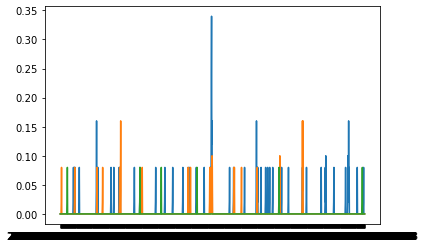

In [ ]:
plt.plot(collectd_ts['gpu1']['cpu-0']['cpu-softirq'].dropna())
plt.plot(collectd_ts['gpu1']['cpu-1']['cpu-softirq'].dropna())
plt.plot(collectd_ts['gpu1']['cpu-2']['cpu-softirq'].dropna())

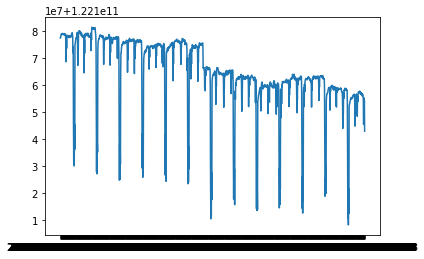

In [ ]:
plt.plot(collectd_ts['gpu1']['memory']['memory-free'].dropna())

In [ ]:
collectd_ts['gpu1'].dropna(axis=0, how='all')

component              cpu-0                                               \
rrd                 cpu-idle cpu-interrupt cpu-nice cpu-softirq cpu-steal   
data_source            value         value    value       value     value   
time                                                                        
2019-07-24 07:02:46      NaN           NaN      NaN         NaN       NaN   
2019-07-24 07:02:56      NaN           NaN      NaN         NaN       NaN   
2019-07-24 07:03:06      NaN           NaN      NaN         NaN       NaN   
2019-07-24 07:03:16      NaN           NaN      NaN         NaN       NaN   
2019-07-24 07:03:26      NaN           NaN      NaN         NaN       NaN   
...                      ...           ...      ...         ...       ...   
2023-05-20 04:11:13      NaN           NaN      NaN         NaN       NaN   
2023-05-20 04:11:15      NaN           NaN      NaN         NaN       NaN   
2023-05-20 04:11:16      NaN           NaN      NaN         NaN       NaN   
2023-05-20 04:11:18     99.6           0.0      0.0         0.0       0.0   
2023-05-20 04:11:23      NaN           NaN      NaN         NaN       NaN   

component                                           cpu-1                ...  \
rrd                 cpu-system cpu-user cpu-wait cpu-idle cpu-interrupt  ...   
data_source              value    value    value    value         value  ...   
time                                                                     ...   
2019-07-24 07:02:46        NaN      NaN      NaN      NaN           NaN  ...   
2019-07-24 07:02:56        NaN      NaN      NaN      NaN           NaN  ...   
2019-07-24 07:03:06        NaN      NaN      NaN      NaN           NaN  ...   
2019-07-24 07:03:16        NaN      NaN      NaN      NaN           NaN  ...   
2019-07-24 07:03:26        NaN      NaN      NaN      NaN           NaN  ...   
...                        ...      ...      ...      ...           ...  ...   
2023-05-20 04:11:13        NaN      NaN      NaN      NaN           NaN  ...   
2023-05-20 04:11:15        NaN      NaN      NaN      NaN           NaN  ...   
2023-05-20 04:11:16        NaN      NaN      NaN      NaN           NaN  ...   
2023-05-20 04:11:18       0.08      0.0     0.18     99.9           0.0  ...   
2023-05-20 04:11:23        NaN      NaN      NaN      NaN           NaN  ...   

component           sensors-coretemp-isa-0000                    \
rrd                         temperature-temp6 temperature-temp7   
data_source                             value             value   
time                                                              
2019-07-24 07:02:46                       NaN               NaN   
2019-07-24 07:02:56                       NaN               NaN   
2019-07-24 07:03:06                       NaN               NaN   
2019-07-24 07:03:16                       NaN               NaN   
2019-07-24 07:03:26                       NaN               NaN   
...                                       ...               ...   
2023-05-20 04:11:13                       NaN               NaN   
2023-05-20 04:11:15                      26.5              24.0   
2023-05-20 04:11:16                       NaN               NaN   
2023-05-20 04:11:18                       NaN               NaN   
2023-05-20 04:11:23                       NaN               NaN   

component           sensors-coretemp-isa-0001                    \
rrd                         temperature-temp1 temperature-temp2   
data_source                             value             value   
time                                                              
2019-07-24 07:02:46                       NaN               NaN   
2019-07-24 07:02:56                       NaN               NaN   
2019-07-24 07:03:06                       NaN               NaN   
2019-07-24 07:03:16                       NaN               NaN   
2019-07-24 07:03:26                       NaN               NaN   
...                               

In [ ]:
collectd_ts['gpu1']['memory']['memory-free'].dropna()

data_source,value
time,
2023-05-20 00:51:28,1.221774e+11
2023-05-20 00:51:38,1.221775e+11
2023-05-20 00:51:48,1.221781e+11
2023-05-20 00:51:58,1.221781e+11
2023-05-20 00:52:08,1.221789e+11
...,...
2023-05-20 04:10:38,1.221455e+11
2023-05-20 04:10:48,1.221553e+11
2023-05-20 04:10:58,1.221500e+11


In [ ]:
collectd_ts['gpu2']['memory']['memory-free'].dropna()

data_source,value
time,
2023-07-19 22:37:01,3.585449e+10
2023-07-19 22:37:11,3.585429e+10
2023-07-19 22:37:21,3.585650e+10
2023-07-19 22:37:31,3.585207e+10
2023-07-19 22:37:41,3.585471e+10
...,...
2023-07-20 01:56:11,3.744862e+10
2023-07-20 01:56:21,3.744797e+10
2023-07-20 01:56:31,3.744747e+10


In [ ]:
snmp_ts = get_time_series_data_for_snmp_server(local_config.rrd_dir, snmp_server='gpu1')

In [ ]:
snmp_ts

rrd                 ucd_diskio-dm-0                                     \
data_source                    read       written     reads     writes   
time                                                                     
2023-03-19 04:11:02             NaN           NaN       NaN        NaN   
2023-03-19 04:11:03        6.915904  73623.655324  0.001458  13.980074   
2023-03-19 04:16:02             NaN           NaN       NaN        NaN   
2023-03-19 04:16:03       25.748490  71521.271793  0.003347  13.599638   
2023-03-19 04:21:02             NaN           NaN       NaN        NaN   
...                             ...           ...       ...        ...   
2023-05-16 06:40:41             NaN           NaN       NaN        NaN   
2023-05-16 06:40:43             NaN           NaN       NaN        NaN   
2023-05-16 06:45:41             NaN           NaN       NaN        NaN   
2023-05-16 06:45:43             NaN           NaN       NaN        NaN   
2023-05-16 06:50:41             NaN           NaN       NaN        NaN   

rrd                 hr_processes ucd_diskio-sda2                          \
data_source                procs            read       written     reads   
time                                                                       
2023-03-19 04:11:02          NaN             NaN           NaN       NaN   
2023-03-19 04:11:03   406.040000        6.915904  73623.655324  0.001458   
2023-03-19 04:16:02          NaN             NaN           NaN       NaN   
2023-03-19 04:16:03   407.973889       25.748490  71521.271793  0.003347   
2023-03-19 04:21:02          NaN             NaN           NaN       NaN   
...                          ...             ...           ...       ...   
2023-05-16 06:40:41          NaN             NaN           NaN       NaN   
2023-05-16 06:40:43          NaN             NaN           NaN       NaN   
2023-05-16 06:45:41          NaN             NaN           NaN       NaN   
2023-05-16 06:45:43          NaN             NaN           NaN       NaN   
2023-05-16 06:50:41          NaN             NaN           NaN       NaN   

rrd                            hr_users  ... ucd_ssCpuRawSoftIRQ  \
data_source             writes    users  ...               value   
time                                     ...                       
2023-03-19 04:11:02        NaN      NaN  ...            0.350956   
2023-03-19 04:11:03  13.893399      1.0  ...                 NaN   
2023-03-19 04:16:02        NaN      NaN  ...            0.514963   
2023-03-19 04:16:03  13.535700      1.0  ...                 NaN   
2023-03-19 04:21:02        NaN      NaN  ...            1.205335   
...                        ...      ...  ...                 ...   
2023-05-16 06:40:41        NaN      NaN  ...                 NaN   
2023-05-16 06:40:43        NaN      NaN  ...                 NaN   
2023-05-16 06:45:41        NaN      NaN  ...                 NaN   
2023-05-16 06:45:43        NaN      NaN  ...                 NaN   
2023-05-16 06:50:41        NaN      NaN  ...                 NaN   

rrd                 ucd_ssCpuRawSystem ucd_ssCpuRawUser ucd_ssCpuRawWait  \
data_source                      value            value            value   
time                                                                       
2023-03-19 04:11:02          73.908736        93.356624         2.434356   
2023-03-19 04:11:03                NaN              NaN              NaN   
2023-03-19 04:16:02          76.327478        94.458425         2.521104   
2023-03-19 04:16:03                NaN              NaN              NaN   
2023-03-19 04:21:02         130.801242        94.001863         2.691549   
...                                ...              ...              ...   
2023-05-16 06:40:41                NaN              NaN              NaN   
2023-05-16 06:40:43                NaN              NaN              NaN   
2023-05-16 06:45:41                NaN              NaN              NaN   
2023-05-16 06:45:43              

In [ ]:
collectd_features_with_matching_timestamps = get_collectd_features_with_matching_timestamps(
    local_config.rrd_dir,
    collectd_server='gpu1'
    )

In [ ]:
collectd_features_with_matching_timestamps.keys()

dict_keys([1, 8, 6, 57, 225, 2])

In [ ]:
collectd_features_with_matching_timestamps[225]

component              cpu-0                                               \
rrd                 cpu-idle cpu-interrupt cpu-nice cpu-softirq cpu-steal   
data_source            value         value    value       value     value   
time                                                                        
2023-05-20 00:51:28    99.70           0.0      0.0        0.00       0.0   
2023-05-20 00:51:38    99.72           0.0      0.0        0.00       0.0   
2023-05-20 00:51:48    99.78           0.0      0.0        0.00       0.0   
2023-05-20 00:51:58    99.68           0.0      0.0        0.00       0.0   
2023-05-20 00:52:08    99.62           0.0      0.0        0.00       0.0   
...                      ...           ...      ...         ...       ...   
2023-05-20 04:10:38    99.70           0.0      0.0        0.08       0.0   
2023-05-20 04:10:48    99.66           0.0      0.0        0.00       0.0   
2023-05-20 04:10:58    95.64           0.0      0.0        0.00       0.0   
2023-05-20 04:11:08    84.08           0.0      0.0        0.00       0.0   
2023-05-20 04:11:18    99.60           0.0      0.0        0.00       0.0   

component                                           cpu-1                ...  \
rrd                 cpu-system cpu-user cpu-wait cpu-idle cpu-interrupt  ...   
data_source              value    value    value    value         value  ...   
time                                                                     ...   
2023-05-20 00:51:28       0.02     0.02     0.12   100.00           0.0  ...   
2023-05-20 00:51:38       0.08     0.08     0.18    99.98           0.0  ...   
2023-05-20 00:51:48       0.02     0.00     0.10    99.92           0.0  ...   
2023-05-20 00:51:58       0.10     0.02     0.10   100.00           0.0  ...   
2023-05-20 00:52:08       0.10     0.08     0.12    99.98           0.0  ...   
...                        ...      ...      ...      ...           ...  ...   
2023-05-20 04:10:38       0.02     0.02     0.10    99.92           0.0  ...   
2023-05-20 04:10:48       0.10     0.08     0.10    99.96           0.0  ...   
2023-05-20 04:10:58       0.12     0.00     3.98    99.78           0.0  ...   
2023-05-20 04:11:08       0.18     0.00    15.64    99.74           0.0  ...   
2023-05-20 04:11:18       0.08     0.00     0.18    99.90           0.0  ...   

component           interface-lo      load                           memory  \
rrd                   if_packets      load                  memory-buffered   
data_source                   tx shortterm midterm longterm           value   
time                                                                          
2023-05-20 00:51:28          0.0     0.174   0.398    0.470       3100672.0   
2023-05-20 00:51:38          0.0     0.146   0.388    0.468       3100672.0   
2023-05-20 00:51:48          0.0     0.126   0.376    0.460       3100672.0   
2023-05-20 00:51:58          0.0     0.106   0.358    0.458       3100672.0   
2023-05-20 00:52:08          0.0     0.088   0.348    0.450       3100672.0   
...                          ...       ...     ...      ...             ...   
2023-05-20 04:10:38          0.0     0.184   0.288    0.430       3100672.0   
2023-05-20 04:10:48          0.0     0.156   0.278    0.430       3100672.0   
2023-05-20 04:10:58          0.0     0.136   0.268    0.428       3100672.0   
2023-05-20 04:11:08          0.0     0.132   0.262    0.420       3100672.0   
2023-05-20 04:11:18          0.0     0.206   0.274    0.422       3100672.0   

component                                                         \
rrd                 memory-cached   memory-free memory-slab_recl   
data_source                 value         value            value   
time                                                               
2023-05-20 00:51:28  7.505963e+09  1.221774e+11      508661760.0   
2023-05-20 00:51:38  7.505968e+09  1.221775e+11      508663398.4   
2023-05-20 00:51:48  7.505965e+09  1.221781e+11  

In [ ]:
snmp_features_with_matching_timestamps = get_snmp_features_with_matching_timestamps(local_config.rrd_dir,snmp_server='gpu1')

In [ ]:
snmp_server='gpu1'
rrd ='ipSystemStats-ipv4'

In [ ]:
feature_df = get_time_series_data_for_single_snmp_rrd(local_config.rrd_dir, snmp_server='gpu1', rrd ='ipSystemStats-ipv4')

In [ ]:
feature_df

rrd                 ipSystemStats-ipv4                           \
data_source                 InReceives InHdrErrors InAddrErrors   
time                                                              
2023-03-19 04:11:02          58.291127         0.0          0.0   
2023-03-19 04:16:02          59.942266         0.0          0.0   
2023-03-19 04:21:02          60.897666         0.0          0.0   
2023-03-19 04:26:02          59.037747         0.0          0.0   
2023-03-19 04:31:02          60.946531         0.0          0.0   
...                                ...         ...          ...   
2023-03-29 11:46:02           1.894378         0.0          0.0   
2023-03-29 11:51:02           1.907145         0.0          0.0   
2023-03-29 11:56:02           1.898335         0.0          0.0   
2023-03-29 12:01:02           1.921045         0.0          0.0   
2023-03-29 12:06:02           1.954822         0.0          0.0   

rrd                                                                      \
data_source         InUnknownProtos InForwDatagrams ReasmReqds ReasmOKs   
time                                                                      
2023-03-19 04:11:02             0.0             0.0        0.0      0.0   
2023-03-19 04:16:02             0.0             0.0        0.0      0.0   
2023-03-19 04:21:02             0.0             0.0        0.0      0.0   
2023-03-19 04:26:02             0.0             0.0        0.0      0.0   
2023-03-19 04:31:02             0.0             0.0        0.0      0.0   
...                             ...             ...        ...      ...   
2023-03-29 11:46:02             0.0             0.0        0.0      0.0   
2023-03-29 11:51:02             0.0             0.0        0.0      0.0   
2023-03-29 11:56:02             0.0             0.0        0.0      0.0   
2023-03-29 12:01:02             0.0             0.0        0.0      0.0   
2023-03-29 12:06:02             0.0             0.0        0.0      0.0   

rrd                                                                           \
data_source         ReasmFails InDiscards InDelivers OutRequests OutNoRoutes   
time                                                                           
2023-03-19 04:11:02        0.0        0.0  58.291127   22.372256         0.0   
2023-03-19 04:16:02        0.0        0.0  59.942266   23.392986         0.0   
2023-03-19 04:21:02        0.0        0.0  60.897666   22.540580         0.0   
2023-03-19 04:26:02        0.0        0.0  59.037747   21.904477         0.0   
2023-03-19 04:31:02        0.0        0.0  60.946531   22.594325         0.0   
...                        ...        ...        ...         ...         ...   
2023-03-29 11:46:02        0.0        0.0   1.887446    3.707309         0.0   
2023-03-29 11:51:02        0.0        0.0   1.902151    3.740145         0.0   
2023-03-29 11:56:02        0.0        0.0   1.898335    3.726709         0.0   
2023-03-29 12:01:02        0.0        0.0   1.921045    3.766684         0.0   
2023-03-29 12:06:02        0.0        0.0   1.934061    3.787767         0.0   

rrd                                                                           
data_source         OutDiscards OutFragFails OutFragCreates OutForwDatagrams  
time                                                                          
2023-03-19 04:11:02         0.0          0.0            0.0              0.0  
2023-03-19 04:16:02         0.0          0.0            0.0              0.0  
2023-03-19 04:21:02         0.0          0.0            0.0              0.0  
2023-03-19 04:26:02         0.0          0.0            0.0              0.0  
2023-03-19 04:31:02         0.0          0.0            0.0              0.0  
...                         ...          ...            ...              ...  
2023-03-29 11:46:02         0.0          0.0            0.0              0.0  
2023-03-29 11:51:02         0.0          0.0            0.0              0.0  
2023-03-29 11:56:02 

In [ ]:
get_available_component_names_for_collectd_server(
    local_config.rrd_dir,
    collectd_server='gpu1'
    )

['cpu-0',
 'cpu-1',
 'cpu-10',
 'cpu-11',
 'cpu-12',
 'cpu-13',
 'cpu-14',
 'cpu-15',
 'cpu-16',
 'cpu-17',
 'cpu-18',
 'cpu-19',
 'cpu-2',
 'cpu-20',
 'cpu-21',
 'cpu-22',
 'cpu-23',
 'cpu-3',
 'cpu-4',
 'cpu-5',
 'cpu-6',
 'cpu-7',
 'cpu-8',
 'cpu-9',
 'dns',
 'interface-eno1',
 'interface-eno2',
 'interface-lo',
 'ipmi',
 'load',
 'memory',
 'sensors-coretemp-isa-0000',
 'sensors-coretemp-isa-0001',
 'sensors-i350bb-pci-8100']

In [ ]:
get_available_rrd_names_for_collectd_server_component(
    local_config.rrd_dir,
    collectd_server='gpu1',
    component='memory'
    )

['memory-buffered',
 'memory-cached',
 'memory-free',
 'memory-slab_recl',
 'memory-slab_unrecl',
 'memory-used']

In [ ]:
collectd_ts['gpu1']

rrd,memory-buffered,memory-cached,memory-free,memory-slab_recl,memory-slab_unrecl,memory-used
data_source,value,value,value,value,value,value
time,,,,,,
2019-07-24 07:02:46,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-24 07:02:56,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-24 07:03:06,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-24 07:03:16,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-24 07:03:26,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2023-05-20 04:11:13,NaN,NaN,NaN,NaN,NaN,NaN
2023-05-20 04:11:15,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
get_available_snmp_server_names(local_config.rrd_dir)

['apc00edfc',
 'apc5f87f5',
 'apc9d5b55',
 'apc9d672d',
 'apc84dae5',
 'apc84e14c',
 'apcdc147c',
 'apce2d8cc',
 'apcf10e82',
 'apollo',
 None,
 'ari',
 'athena',
 'atlas',
 'bhyve',
 'deimos',
 'denver',
 'foxconn',
 'gaia',
 'gpu1',
 'gpu2',
 'gpu3',
 'gpu4',
 'gpu5',
 'gpu6',
 'gpu7',
 'gpu8',
 'gpu9',
 'gpu10',
 'gpu11',
 'gpu12',
 'gpu13',
 'gpu14',
 'gpu15',
 'gpu16',
 'gpu17',
 'gpu18',
 'gpu19',
 'gpu20',
 'gpu21',
 'gpu22',
 'gpu23',
 'gpu24',
 'gpu25',
 'gpu26',
 'gpu27',
 'horae.dmz.autonlab.org',
 'lnet1',
 'lnet2.dmz.autonlab.org',
 'lnet3',
 'lnet5',
 'lnms',
 'lock.dmz.autonlab.org',
 'lov1',
 'lov2',
 'lov3',
 'lov4',
 'lov5',
 'lov6',
 'lov7',
 'lov8',
 'lov9',
 'lov10',
 'lov11',
 'lov12',
 'lov13',
 'neill-zfs',
 'ourea',
 'pdu-b',
 'pdu-c',
 'phobos',
 'uranus',
 'warden',
 'xen1']

In [ ]:
get_available_component_names_for_collectd_server(local_config.rrd_dir,collectd_server='gpu10')

['cpu-0',
 'cpu-1',
 'cpu-10',
 'cpu-11',
 'cpu-12',
 'cpu-13',
 'cpu-14',
 'cpu-15',
 'cpu-16',
 'cpu-17',
 'cpu-18',
 'cpu-19',
 'cpu-2',
 'cpu-20',
 'cpu-21',
 'cpu-22',
 'cpu-23',
 'cpu-24',
 'cpu-25',
 'cpu-26',
 'cpu-27',
 'cpu-28',
 'cpu-29',
 'cpu-3',
 'cpu-30',
 'cpu-31',
 'cpu-4',
 'cpu-5',
 'cpu-6',
 'cpu-7',
 'cpu-8',
 'cpu-9',
 'dns',
 'interface-eno1',
 'interface-eno2',
 'interface-lo',
 'ipmi',
 'load',
 'memory',
 'sensors-coretemp-isa-0000',
 'sensors-coretemp-isa-0001']

In [ ]:
l = get_available_rrd_names_for_snmp_server(local_config.rrd_dir,snmp_server='gpu10')

In [ ]:
l

array(['processor-hr-196631', 'hr_processes', 'ucd_diskio-dm-1',
       'hr_users', 'processor-hr-196617', 'ipSystemStats-ipv4',
       'processor-hr-196618', 'ipSystemStats-ipv6', 'ucd_cpu', 'la',
       'perf-pollermodule-ucd-mib', 'mempool-host-resources-mib--10',
       'perf-pollermodule-wifi', 'mempool-host-resources-mib--3',
       'perf-pollersnmp', 'ucd_mem', 'mempool-host-resources-mib--6',
       'processor-hr-196619', 'mempool-ucd-snmp-mib--0',
       'processor-hr-196632', 'netstats-icmp', 'processor-hr-196633',
       'netstats-ip', 'processor-hr-196634', 'netstats-snmp',
       'processor-hr-196635', 'netstats-tcp', 'processor-hr-196636',
       'netstats-udp', 'processor-hr-196637', 'perf-poller',
       'processor-hr-196638', 'perf-pollerdb', 'processor-hr-196620',
       'perf-pollermemory', 'ping', 'ucd_diskio-dm-0',
       'perf-pollermodule-applications', 'perf-pollersnmp_errors',
       'perf-pollermodule-bgp-peers', 'ping_snmp', 'uptime',
       'perf-pollermodul

In [ ]:
lf = [x for x in l if 'sensor-temper' in x]
lf.sort()

In [ ]:
lf

['sensor-temperature-LM-SENSORS-MIB-lmTempSensorsValue-1',
 'sensor-temperature-LM-SENSORS-MIB-lmTempSensorsValue-10',
 'sensor-temperature-LM-SENSORS-MIB-lmTempSensorsValue-11',
 'sensor-temperature-LM-SENSORS-MIB-lmTempSensorsValue-12',
 'sensor-temperature-LM-SENSORS-MIB-lmTempSensorsValue-13',
 'sensor-temperature-LM-SENSORS-MIB-lmTempSensorsValue-14',
 'sensor-temperature-LM-SENSORS-MIB-lmTempSensorsValue-15',
 'sensor-temperature-LM-SENSORS-MIB-lmTempSensorsValue-16',
 'sensor-temperature-LM-SENSORS-MIB-lmTempSensorsValue-17',
 'sensor-temperature-LM-SENSORS-MIB-lmTempSensorsValue-18',
 'sensor-temperature-LM-SENSORS-MIB-lmTempSensorsValue-19',
 'sensor-temperature-LM-SENSORS-MIB-lmTempSensorsValue-2',
 'sensor-temperature-LM-SENSORS-MIB-lmTempSensorsValue-20',
 'sensor-temperature-LM-SENSORS-MIB-lmTempSensorsValue-21',
 'sensor-temperature-LM-SENSORS-MIB-lmTempSensorsValue-22',
 'sensor-temperature-LM-SENSORS-MIB-lmTempSensorsValue-23',
 'sensor-temperature-LM-SENSORS-MIB-lmTemp

In [ ]:
get_available_rrd_names_for_collectd_server_component(
    local_config.rrd_dir,
    collectd_server='gpu1',
    component='sensors-coretemp-isa-0001'
    )

['temperature-temp1']

In [ ]:
df = get_time_series_data_for_snmp_server(local_config.rrd_dir, 'gpu10')

In [ ]:
df['port-1'].dropna().iloc[:10]

data_source,INOCTETS,OUTOCTETS,INERRORS,OUTERRORS,INUCASTPKTS,OUTUCASTPKTS,INNUCASTPKTS,OUTNUCASTPKTS,INDISCARDS,OUTDISCARDS,INUNKNOWNPROTOS,INBROADCASTPKTS,OUTBROADCASTPKTS,INMULTICASTPKTS,OUTMULTICASTPKTS
time,,,,,,,,,,,,,,,
2023-05-05 22:45:33,4.637467,4.637467,0.0,0.0,0.058588,0.058588,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-05-05 22:50:33,1.907330,1.907330,0.0,0.0,0.015575,0.015575,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-05-05 22:55:33,1.907601,1.907601,0.0,0.0,0.015568,0.015568,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-05-05 23:00:33,1.906775,1.906775,0.0,0.0,0.015575,0.015575,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-05-05 23:05:33,31.971077,31.971077,0.0,0.0,0.118175,0.118175,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-05-05 23:10:33,1.878005,1.878005,0.0,0.0,0.015676,0.015676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-05-05 23:15:33,325.589402,325.589402,0.0,0.0,2.952300,2.952300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-05-05 23:20:33,441.146540,441.146540,0.0,0.0,4.296991,4.296991,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-05-05 23:25:33,723.919690,723.919690,0.0,0.0,6.700753,6.700753,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df['port-2'].dropna().iloc[:10]

data_source,INOCTETS,OUTOCTETS,INERRORS,OUTERRORS,INUCASTPKTS,OUTUCASTPKTS,INNUCASTPKTS,OUTNUCASTPKTS,INDISCARDS,OUTDISCARDS,INUNKNOWNPROTOS,INBROADCASTPKTS,OUTBROADCASTPKTS,INMULTICASTPKTS,OUTMULTICASTPKTS
time,,,,,,,,,,,,,,,
2023-05-05 22:35:43,1854.551934,3879.517473,0.0,0.0,10.434254,12.791261,0.001768,0.0,0.0,0.0,0.0,0.0,0.0,0.001768,0.0
2023-05-05 22:40:43,316.641816,2178.284986,0.0,0.0,2.200550,4.267328,0.002120,0.0,0.0,0.0,0.0,0.0,0.0,0.002120,0.0
2023-05-05 22:45:43,1740.372160,3709.670644,0.0,0.0,10.020323,12.111670,0.001769,0.0,0.0,0.0,0.0,0.0,0.0,0.001769,0.0
2023-05-05 22:50:43,491.569871,2387.524449,0.0,0.0,3.188481,5.202674,0.002122,0.0,0.0,0.0,0.0,0.0,0.0,0.002122,0.0
2023-05-05 22:55:43,25350.222354,27880.746581,0.0,0.0,140.250452,149.718547,0.001656,0.0,0.0,0.0,0.0,0.0,0.0,0.001656,0.0
2023-05-05 23:00:43,2795.515394,3520.025197,0.0,0.0,5.799808,6.960356,0.001778,0.0,0.0,0.0,0.0,0.0,0.0,0.001778,0.0
2023-05-05 23:05:43,40543.834371,44644.940157,0.0,0.0,238.034035,255.822710,0.002140,0.0,0.0,0.0,0.0,0.0,0.0,0.002140,0.0
2023-05-05 23:10:43,844.545621,2644.724968,0.0,0.0,3.422109,5.662886,0.001749,0.0,0.0,0.0,0.0,0.0,0.0,0.001749,0.0
2023-05-05 23:15:43,23021.925169,26188.050269,0.0,0.0,132.856737,144.980615,0.002140,0.0,0.0,0.0,0.0,0.0,0.0,0.002140,0.0


In [ ]:
df.filter(like='processor-hr-1').mean(axis=1)

time
2023-05-05 22:00:31    0.000000
2023-05-05 22:05:31    0.000000
2023-05-05 22:05:32    0.293194
2023-05-05 22:10:31    0.250000
2023-05-05 22:10:32    0.331806
                         ...   
2023-05-16 06:45:33    0.250799
2023-05-16 06:45:34    0.305463
2023-05-16 06:45:35         NaN
2023-05-16 06:50:32         NaN
2023-05-16 06:50:33    0.219826
Length: 32765, dtype: float64

In [ ]:
df['processor-hr-average-1'].dropna()

data_source,usage
time,
2023-05-05 22:40:23,0.247800
2023-05-05 22:45:23,0.278989
2023-05-05 22:50:23,0.247783
2023-05-05 22:55:23,0.255217
2023-05-05 23:00:23,0.261389
...,...
2023-05-16 06:15:23,0.248267
2023-05-16 06:20:23,0.258689
2023-05-16 06:25:23,0.254133


In [ ]:
df['status'].dropna().value_counts()

status  
1.000000    2890
0.000000       7
0.298889       1
0.696111       1
Name: count, dtype: int64

In [ ]:
df = get_time_series_data_for_collectd_server(local_config.rrd_dir, 'gpu10')

In [ ]:
df

component              cpu-0                                               \
rrd                 cpu-idle cpu-interrupt cpu-nice cpu-softirq cpu-steal   
data_source            value         value    value       value     value   
time                                                                        
2020-05-02 14:05:07      NaN           NaN      NaN         NaN       NaN   
2020-05-02 14:05:17      NaN           NaN      NaN         NaN       NaN   
2020-05-02 14:05:27      NaN           NaN      NaN         NaN       NaN   
2020-05-02 14:05:37      NaN           NaN      NaN         NaN       NaN   
2020-05-02 14:05:47      NaN           NaN      NaN         NaN       NaN   
...                      ...           ...      ...         ...       ...   
2023-07-20 01:56:30      NaN           NaN      NaN         NaN       NaN   
2023-07-20 01:56:36    46.58           0.0      0.0        0.00       0.0   
2023-07-20 01:56:40      NaN           NaN      NaN         NaN       NaN   
2023-07-20 01:56:46    76.24           0.0      0.0        0.04       0.0   
2023-07-20 01:56:50      NaN           NaN      NaN         NaN       NaN   

component                                           cpu-1                ...  \
rrd                 cpu-system cpu-user cpu-wait cpu-idle cpu-interrupt  ...   
data_source              value    value    value    value         value  ...   
time                                                                     ...   
2020-05-02 14:05:07        NaN      NaN      NaN      NaN           NaN  ...   
2020-05-02 14:05:17        NaN      NaN      NaN      NaN           NaN  ...   
2020-05-02 14:05:27        NaN      NaN      NaN      NaN           NaN  ...   
2020-05-02 14:05:37        NaN      NaN      NaN      NaN           NaN  ...   
2020-05-02 14:05:47        NaN      NaN      NaN      NaN           NaN  ...   
...                        ...      ...      ...      ...           ...  ...   
2023-07-20 01:56:30        NaN      NaN      NaN      NaN           NaN  ...   
2023-07-20 01:56:36       1.48    51.26      0.0    81.94           0.0  ...   
2023-07-20 01:56:40        NaN      NaN      NaN      NaN           NaN  ...   
2023-07-20 01:56:46       1.66    21.02      0.0    82.64           0.0  ...   
2023-07-20 01:56:50        NaN      NaN      NaN      NaN           NaN  ...   

component           sensors-coretemp-isa-0000 sensors-coretemp-isa-0001  \
rrd                         temperature-temp9         temperature-temp1   
data_source                             value                     value   
time                                                                      
2020-05-02 14:05:07                       NaN                       NaN   
2020-05-02 14:05:17                       NaN                       NaN   
2020-05-02 14:05:27                       NaN                       NaN   
2020-05-02 14:05:37                       NaN                       NaN   
2020-05-02 14:05:47                       NaN                       NaN   
...                                       ...                       ...   
2023-07-20 01:56:30                       NaN                       NaN   
2023-07-20 01:56:36                      21.6                      26.0   
2023-07-20 01:56:40                       NaN                       NaN   
2023-07-20 01:56:46                      21.0                      26.0   
2023-07-20 01:56:50                       NaN                       NaN   

component                                                                  \
rrd                 temperature-temp2 temperature-temp3 temperature-temp4   
data_source                     value             value             value   
time                                                                        
2020-05-02 14:05:07               NaN               NaN               NaN   
2020-05-02 14:05:17               NaN               NaN               NaN   
2020-05-02 14:05:27               NaN               NaN

In [ ]:
df['cpu-0']

rrd,cpu-idle,cpu-interrupt,cpu-nice,cpu-softirq,cpu-steal,cpu-system,cpu-user,cpu-wait
data_source,value,value,value,value,value,value,value,value
time,,,,,,,,
2020-05-02 14:05:07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-02 14:05:17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-02 14:05:27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-02 14:05:37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-02 14:05:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2023-07-20 01:56:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-07-20 01:56:36,46.58,0.0,0.0,0.00,0.0,1.48,51.26,0.0
